In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls gdrive/'MyDrive'/'Colab Notebooks'/super-resolution/data/PUC_DIR

'how to open'
 IMG1_dip_FINAL_REF_model_1_true.bin
 IMG1_dip_FINAL_REF_model_1_true_gain.bin
 IMG1_dip_FINAL_REF_model_2_true.bin
 IMG1_dip_FINAL_REF_model_2_true_gain.bin
 mod_vp_05_nx7760_nz1040.bin
 pluto_VP_SI_02.bin
 README_PUC.txt


In [12]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import cv2
from skimage.transform import downscale_local_mean
import math
from skimage.metrics import structural_similarity, mean_squared_error


from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

In [13]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(0)
tf.keras.backend.set_floatx('float32')

In [14]:
tf.__version__

'2.3.0'

# Metrics


In [15]:
def _psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return (20 * math.log10(PIXEL_MAX)) - (10 * math.log10(mse))


def psnr(y, y_pred, verbose=True):
    psnr_sum = 0

    for i in range(len(y)):
        psnr_sum += _psnr(y[i], y_pred[i])

    if verbose:
        print(f"Mean PSNR {psnr_sum / len(y)}")

    return psnr_sum / len(y)


def mse(y, y_pred, verbose=True):
    mse_sum = 0

    for i in range(len(y)):
        mse_sum += mean_squared_error(y[i], y_pred[i])

    if verbose:
        print(f"Mean MSE {mse_sum / len(y)}")

    return mse_sum / len(y)


def ssim(y, y_pred, verbose=True):
    ssim_sum = 0

    for i in range(len(y)):
        ssim_sum += structural_similarity(y[i], y_pred[i])

    if verbose:
        print(f"Mean SSIM {ssim_sum / len(y)}")

    return ssim_sum / len(y)

# Dataset Reader


In [16]:
class ArtificialDatasetReader:
    """
    This class is responsible for loading and pre-processing _data from the artificial dataset
    """

    def __init__(self, dataset_path='../_data/dataset/artificial'):
        self.dataset_path = dataset_path
        self.well_1 = self.load_dataset(
            height=1040,
            length=7760,
            vel_path='mod_vp_05_nx7760_nz1040.bin',
            well_path='IMG1_dip_FINAL_REF_model_1_true.bin',
            edges=(1000, 6900)
        )
        self.well_2 = self.load_dataset(
            height=1216,
            length=6912,
            vel_path='pluto_VP_SI_02.bin',
            well_path='IMG1_dip_FINAL_REF_model_2_true.bin',
            edges=(1400, 5550)
        )

    def get_dataset(self, scale=2, img_size=64, as_cmap=False):
        """
        breaks well image into 'img_size' x 'img_size' images and downscale them by 'scale'
        :param scale: down sampling scale factor
        :param img_size: size of the images in the dataset
        :param as_cmap: boolean to convert the dataset to a 3 channel RGB image
        :return: x_train, y_train, x_val, y_val, x_test, y_test, with
        rescaled cropped images as x and original cropped images as y
        """
        np.random.seed(0)

        shape1 = (img_size * (self.well_1.shape[0] // img_size), img_size * (self.well_1.shape[1] // img_size))
        data_coord1 = [(img_size * i, img_size * j) for i in range(shape1[0] // img_size) for j in
                       range(shape1[1] // img_size)]

        shape2 = (img_size * (self.well_2.shape[0] // img_size), img_size * (self.well_2.shape[1] // img_size))
        data_coord2 = [(img_size * i, img_size * j) for i in range(shape2[0] // img_size) for j in
                       range(shape2[1] // img_size)]

        data = [self.well_1[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord1] + [
            self.well_2[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord2]

        np.random.shuffle(data)

        x = [downscale_local_mean(y, (scale, scale)) for y in data]

        # X train, val and test
        x_train = x[:int(len(x) * 0.5)]
        x_val = x[int(len(x) * 0.5): int(len(x) * 0.7)]
        x_test = x[int(len(x) * 0.7):]

        # Y train, val and test
        y_train = data[:int(len(data) * 0.5)]
        y_val = data[int(len(data) * 0.5): int(len(data) * 0.7)]
        y_test = data[int(len(data) * 0.7):]

        if as_cmap:
            return self.get_cmap(x_train), self.get_cmap(y_train), self.get_cmap(x_val), self.get_cmap(
                y_val), self.get_cmap(x_test), self.get_cmap(y_test)

        return x_train, y_train, x_val, y_val, x_test, y_test

    def load_dataset(self, height, length, vel_path, well_path, edges, normalize=False):
        """
        load well's data from the artificial dataset
        :param height: well height
        :param length: well length
        :param vel_path: vel csv file name
        :param well_path: well csv file name
        :param edges: tuple containing lower and upper edges limits
        :param normalize: boolean to normalize the dataset
        :return: numpy array with well's data
        """
        with open(os.path.join(self.dataset_path, vel_path), 'rb') as f:
            vel_data = np.fromfile(f, dtype=np.float32)
            vel = np.reshape(vel_data, [length, height])
            vel = vel.T

            # Cutting edges with repeated _data
            vel = vel[:, edges[0]:edges[1]]

        with open(os.path.join(self.dataset_path, well_path), 'rb') as f:
            well_data = np.fromfile(f, dtype=np.float32)
            well = np.reshape(well_data, [length, height])
            well = well.T

            # Cutting edges with repeated _data
            well = well[:, edges[0]:edges[1]]

            # Clean Water
            i_max = 0
            min_vel = np.min(vel)
            for i in range(vel.shape[0]):
                for j in range(vel.shape[1]):
                    if (vel[i, j] <= min_vel) and (i > i_max):
                        i_max = i
            well = well[i_max:, :]

            # Normalizing
            if normalize:
                well = self._normalize(well)

        return well

    @staticmethod
    def _normalize(well):
        """
        min max normalization
        :param well: numpy array containing the well _data
        :return: normalized well
        """
        well -= np.min(well)
        well /= np.max(well) - np.min(well)

        return well

    @classmethod
    def get_cmap(cls, array):
        """
        convert an 'array' to a 3 channel RGB image
        :param array: 2 dimension numpy array
        :return: 3 channel RGB numpy array
        """
        array_rgb = []
        for i in range(len(array)):
            cmap = plt.get_cmap('seismic')
            norm = plt.Normalize()
            output = cmap(norm(array[i]))[:, :, :3]
            array_rgb.append(output)

        return np.array(array_rgb)


Definição das variaveis:
```
n1 - (número de amostras (linhas da imagem pixel))
n2 - (número de tracos (colunas da imagem)
d1 e d2 - (intervalo de amostragem nas direções X e Y)
VMIN e VMAX - (valores máximo e mínimo de velocidades, porpriedades (o valor de 4500 corresponde ao sal)
```

- Modelo 1 - SEG/EAGE Modified -
	- Arquivo de velocidades: mod_vp_05_nx7760_nz1040.bin 
	- Imagem migrada: IMG1_dip_FINAL_REF_model_1_true.bin
	- n1=1040 ; n2=7760 
	- d1=5    ; d2=5  
	- VMIN=1500 ; VMAX=4500 

- Modelo 2 - Pluto -
	- Arquivo de velocidades: pluto_VP_SI_02.bin 
	- Imagem migrada: IMG1_dip_FINAL_REF_model_2_true.bin
	- n1=1216 ; n2=6912
	- d1=7.62 ; d2=7.62
	- VMIN=1490 ; VMAX=4550

## Pre Processamento

- Remoção da área superior da imagem do reservatorio referente ao mar
    - **18.21%** na Imagem 1
    - **5.76%** na Imagem 2

- Geraçao da entrada atraves de **Downsampling** utilizando a média local


In [17]:
# Concatenacao de ambos os modelos
dr = ArtificialDatasetReader(dataset_path="gdrive/My Drive/Colab Notebooks/super-resolution/data/PUC_DIR")

In [18]:
x_train, y_train, x_val, y_val, _, _ = dr.get_dataset(img_size=64)

In [19]:
x_train[0].shape, y_train[0].shape

((32, 32), (64, 64))

A esquerda imagem com resolucao reduzida em 2x, a direita imagem com resolucao original


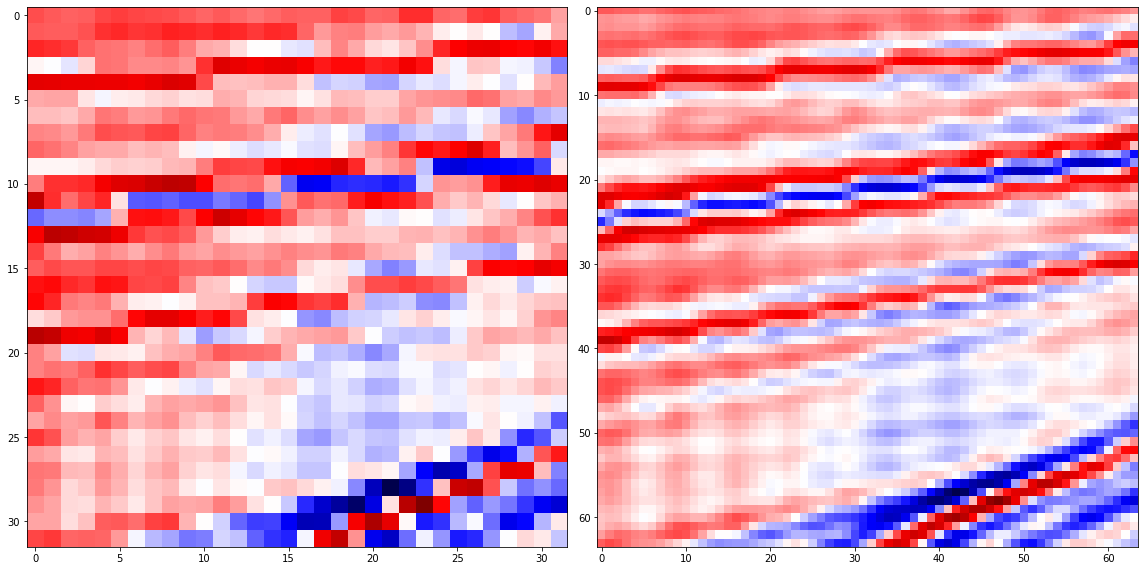

In [31]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(x_train[9], cmap='seismic')
ax[1].imshow(y_train[9], cmap='seismic')
print('A esquerda imagem com resolucao reduzida em 2x, a direita imagem com resolucao original')
plt.tight_layout()
plt.show()

# Baseline

In [33]:
class Baseline:
    """"
    Bi-cubic interpolation baseline
    """
    def __init__(self, scale=2):
        self.scale = scale

    def predict(self, x):
        return [cv2.resize(img, (img.shape[0]*self.scale, img.shape[1]*self.scale)) for img in x]

    def evaluate(self, x, y):
        y_pred = self.predict(x)

        metrics = {'mse': [mse(y, y_pred)],
                   'psnr': [psnr(y, y_pred)]}

        return pd.DataFrame(metrics)


In [34]:
bl = Baseline()

In [36]:
baseline = Baseline()
y_b = baseline.predict(x_val)
_ = baseline.evaluate(x_val, y_val)

Mean MSE 0.00011248492051322858
Mean PSNR 54.2920428363744


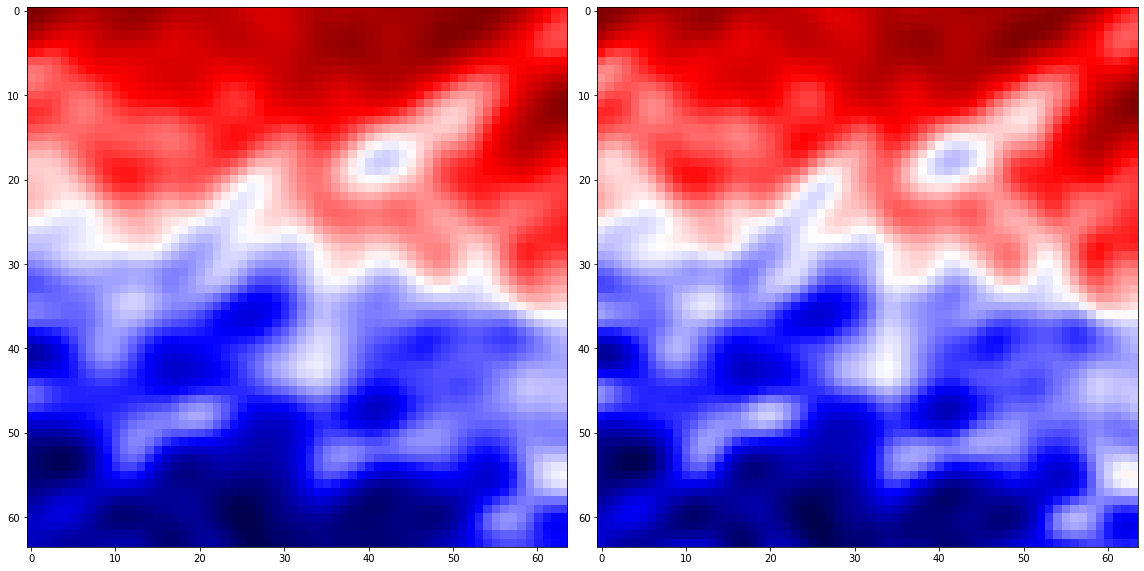

In [37]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[1], cmap='seismic')

ax[1].imshow(y_val[1], cmap='seismic')

plt.tight_layout()
plt.show()

# Model

Modelo baseado no artigo **Residual Dense Network for Image Super-Resolution**(https://arxiv.org/pdf/1802.08797.pdf)

<figure>
<center>
<img src="http://drive.google.com/uc?export=view&id=1NzDk04zLhpz1NhbSAIDg3ppmnf6mPpku" />
<figcaption>Arquitetura</figcaption></center>
</figure>

<figure>
<center>
<img src="http://drive.google.com/uc?export=view&id=129ut7lgUAO5TE3psQ6KoofXPUtK9oecK" />
<figcaption>Bloco RDB</figcaption></center>
</figure>


In [61]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self, base_name, init_shape, learning_rate=0.001, loss='mae', **kwargs):
        super(NeuralNetwork, self).__init__(name=base_name, **kwargs)

        self.base_name = base_name

        self.loss_name = loss

        self.init_shape = init_shape

        self.learning_rate = learning_rate
        self.total_epochs = 0

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        if loss.lower() == 'mae':
            self.loss_metric = tf.keras.metrics.MeanAbsoluteError()
            self.loss = tf.keras.losses.MeanAbsoluteError()
        elif loss.lower() == 'mse':
            self.loss_metric = tf.keras.metrics.MeanSquaredError()
            self.loss = tf.keras.losses.MeanSquaredError()
        else:
            raise AttributeError('Base class NeuralNetwork only supports mse and mae losses')

        self.log_metrics = defaultdict(list)

    def __str__(self):
        return self.get_name()

    def get_architecture_str(self):
        raise NotImplementedError

    def get_name(self):
        return f'{self.base_name}-{self.get_architecture_str()}-ep_{self.total_epochs}'

    def call(self, input_features):
        raise NotImplementedError

    @tf.function
    def train(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x)

            loss_value = self.loss(predictions, y)

            self.loss_metric.update_state(predictions, y)

            gradients = tape.gradient(loss_value, self.trainable_variables)

            gradient_variables = zip(gradients, self.trainable_variables)

            self.optimizer.apply_gradients(gradient_variables)

            return loss_value

    def save_weights(self, path='../_data/weights/'):
        name = path + self.get_name() + '.h5'

        super().save_weights(name)

        print(f'weights saved as {name}')
        return name

    def load_weights(self, weights):
        self.total_epochs = int(weights.split('ep_')[-1].split('.h5')[0])

        super().load_weights(weights)

    def create_model(self):
        _ = self(np.random.random_sample((1, *self.init_shape)))

    @staticmethod
    def get_tensor_dataset(x, y, x_val, y_val):
        x_train = tf.data.Dataset.from_tensor_slices(x)
        x_val = tf.data.Dataset.from_tensor_slices(x_val)

        y_train = tf.data.Dataset.from_tensor_slices(y)
        y_val = tf.data.Dataset.from_tensor_slices(y_val)

        return x_train, y_train, x_val, y_val

    def train_epochs(self, x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose=True, frequency=5):
        x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor = self.get_tensor_dataset(
            x_train, y_train, x_val, y_val)
        loss = []
        for epoch in range(n_epochs):
            loss_val = []
            batches_x = x_train_tensor.batch(batch_size)
            batches_y = y_train_tensor.batch(batch_size)

            # Training loop
            for _x, _y in zip(batches_x, batches_y):
                self.train(_x, _y)

            batches_x_val = x_val_tensor.batch(batch_size)
            batches_y_val = y_val_tensor.batch(batch_size)

            # Validation loop
            for _x, _y in zip(batches_x_val, batches_y_val):
                loss_val.append(self.loss(self(_x), _y))

            loss_train = self.loss_metric.result().numpy()

            self.total_epochs += 1

            if verbose:
                if epoch % frequency == 0 or epoch == 0:
                    psnr_val = psnr(y_val, self(x_val), verbose=False)
                    print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)} '
                          f'Validation PSNR: {psnr_val}')

            loss.append(np.mean(loss_val))

            self.log_metrics['loss_train'].append(loss_train)
            self.log_metrics['loss_val'].append(np.mean(loss_val))

            self.loss_metric.reset_states()

        if verbose:
            psnr_val = psnr(y_val, self(x_val), verbose=False)
            print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)} '
                  f'Validation PSNR: {psnr_val}')

        return pd.DataFrame(self.log_metrics)

In [62]:
class RDB(tf.keras.layers.Layer):
    def __init__(self, filters, block_size=3, kernel_size=(3, 3), name='rdb_layer', **kwargs):
        super(RDB, self).__init__(name=name, **kwargs)
        self.filters = filters
        self.block_size = block_size
        self.kernel_size = kernel_size
        self.convs = []

        for i in range(self.block_size):
            self.convs.append(tf.keras.layers.Conv2D(filters=self.filters,
                                                     kernel_size=self.kernel_size,
                                                     activation=tf.nn.relu,
                                                     padding='same',
                                                     name=f'conv_{i}_{self.name}'
                                                     )
                              )

        self.conv_concat = tf.keras.layers.Conv2D(filters=self.filters,
                                                  kernel_size=(1, 1),
                                                  activation=tf.nn.relu,
                                                  padding='same',
                                                  name=f'conv_concat_{self.name}')

    def call(self, x):
        x_list = [x]
        for i in range(self.block_size):
            x_list.append(self.convs[i](sum(x_list[:i + 1])))

        x = self.conv_concat(tf.concat(x_list, axis=-1)) + x

        return x

In [63]:
class ResidualDenseNetwork(NeuralNetwork):
    def __init__(self, init_shape, filters=64, original_dim=64, rdb_blocks=3, rdb_block_size=3,
                 learning_rate=0.0001, activ_hidden=tf.nn.relu, activ_out=tf.nn.tanh, loss='mae', **kwargs):
        super(ResidualDenseNetwork, self).__init__(init_shape=init_shape,
                                                   base_name='ResidualDenseNetwork',
                                                   learning_rate=learning_rate, loss=loss, **kwargs)

        self.resolution = original_dim

        self.activation_hidden_layer = activ_hidden
        self.activation_output_layer = activ_out

        self.filters = filters

        self.sfe1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same',
            name='sfe1_layer'
        )

        self.sfe2 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same',
            name='sfe2_layer'
        )

        # RDB
        self.rdb_block_size = rdb_block_size
        self.rdb = [RDB(filters=filters, block_size=rdb_block_size, name=f'rdb_layer_{i}') for i in range(rdb_blocks)]

        #########

        self.conv1x1 = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same',
            name='conv1x1_layer'
        )

        self.conv_gf = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation=activ_hidden,
            padding='same',
            name='gf_layer'
        )

        self.upsample = tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=(3, 3),
            strides=(2, 2),
            activation=tf.nn.tanh,
            padding='same',
            name=f'upsample_layer'
        )

        self.output_layer = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=(1, 1),
            activation=activ_out,
            padding='same',
            name=f'output_layer'
        )

        self.create_model()

    def get_architecture_str(self):
        return f'a_{self.filters}-rdb_{len(self.rdb)}-bs_{self.rdb_block_size}-' \
               f'hl_{self.activation_hidden_layer.__name__}-ol_{self.activation_output_layer.__name__}'

    def call(self, input_features):
        x = tf.expand_dims(input_features, -1)
        f_m1 = self.sfe1(x)

        f_list = [self.sfe2(f_m1)]

        # RDB
        for i in range(len(self.rdb)):
            f_list.append(self.rdb[i](f_list[i]))

        x = self.conv1x1(tf.concat(f_list[1:], axis=-1))

        f_gf = self.conv_gf(x)

        x = self.upsample(f_gf + f_m1)
        x = self.output_layer(x)

        return tf.reshape(x, (-1, self.resolution, self.resolution))


In [77]:
model = ResidualDenseNetwork(init_shape=(32, 32), filters=64, rdb_block_size=4, rdb_blocks=6)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [78]:
model.summary()

Model: "ResidualDenseNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mean_absolute_error (MeanAbs multiple                  2         
_________________________________________________________________
sfe1_layer (Conv2D)          multiple                  640       
_________________________________________________________________
sfe2_layer (Conv2D)          multiple                  36928     
_________________________________________________________________
rdb_layer_0 (RDB)            multiple                  168256    
_________________________________________________________________
rdb_layer_1 (RDB)            multiple                  168256    
_________________________________________________________________
rdb_layer_2 (RDB)            multiple                  168256    
_________________________________________________________________
rdb_layer_3 (RDB)            multiple         

## Train

In [79]:
result = model.train_epochs(x_train, y_train, x_val, y_val, 500, 64, frequency=25)

Epoch: 0 Train Loss: 0.01391932088881731 Validation Loss: 0.009287120774388313 Validation PSNR: 42.32886329803613
Epoch: 25 Train Loss: 0.0011045003775507212 Validation Loss: 0.0012233071029186249 Validation PSNR: 58.95174591498933
Epoch: 50 Train Loss: 0.0007365357014350593 Validation Loss: 0.000862408778630197 Validation PSNR: 62.18292443496901
Epoch: 75 Train Loss: 0.0009073970140889287 Validation Loss: 0.0008642448228783906 Validation PSNR: 61.66260111025551
Epoch: 100 Train Loss: 0.0006216827314347029 Validation Loss: 0.0007143831462599337 Validation PSNR: 63.43499676307056
Epoch: 125 Train Loss: 0.0005992227816022933 Validation Loss: 0.0007399067981168628 Validation PSNR: 63.5476987509509
Epoch: 150 Train Loss: 0.0005396484630182385 Validation Loss: 0.0007223501452244818 Validation PSNR: 62.75507782242477
Epoch: 175 Train Loss: 0.0005351773579604924 Validation Loss: 0.0005827859858982265 Validation PSNR: 65.34939129445343
Epoch: 200 Train Loss: 0.0004452878492884338 Validation Lo

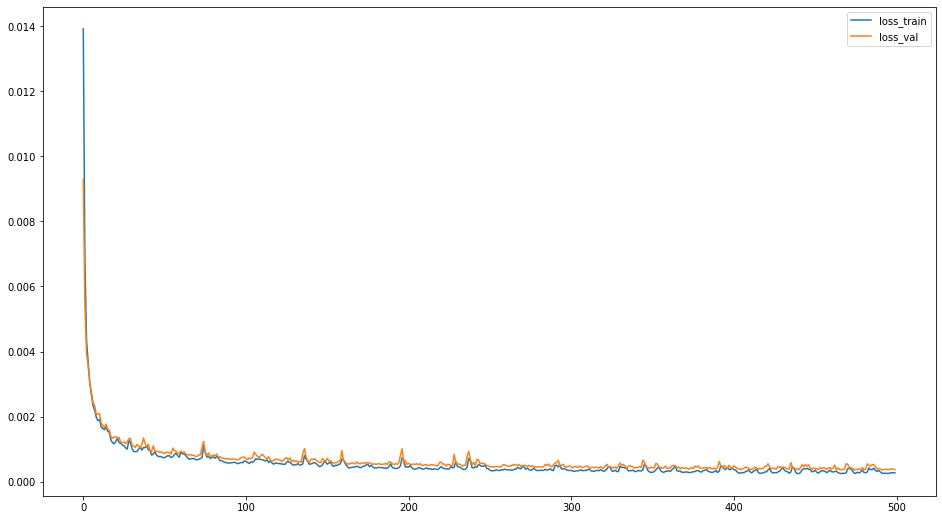

In [80]:
result.plot()

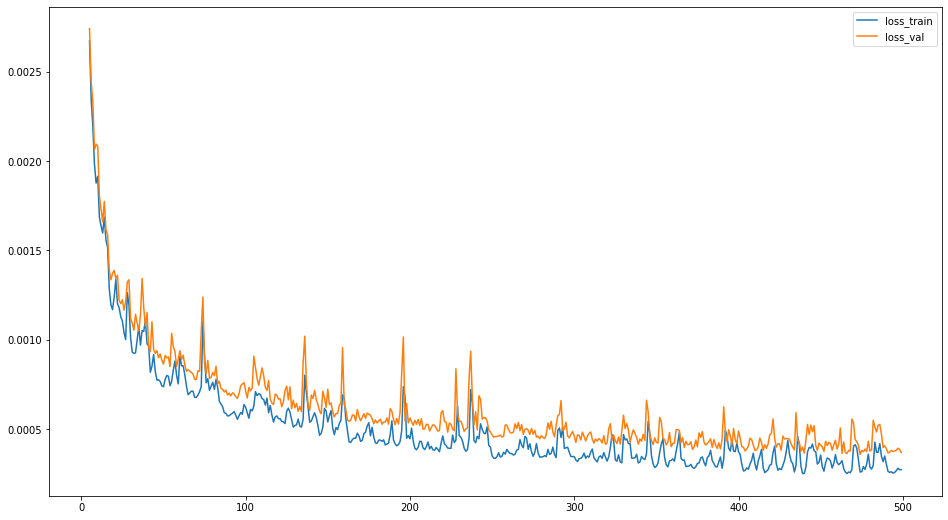

In [81]:
result[5:].plot()

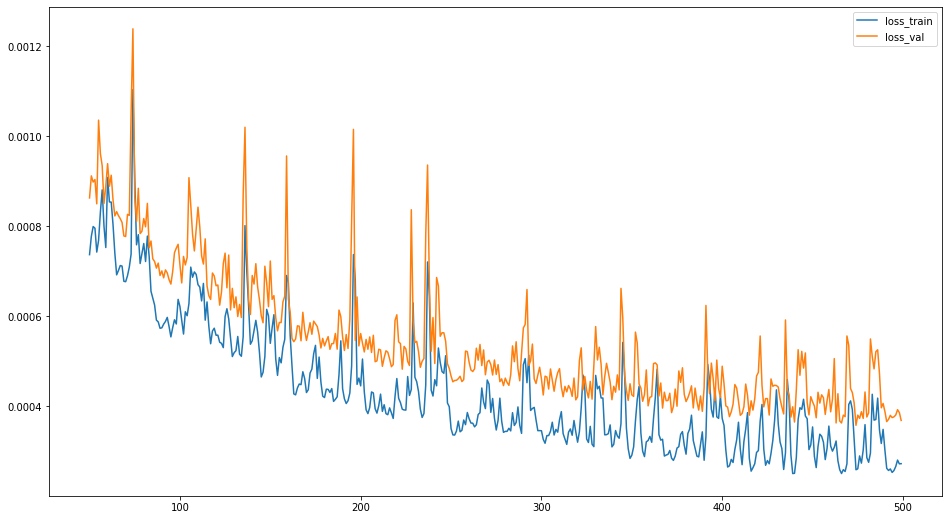

In [82]:
result[50:].plot()

In [83]:
y = model(x_val).numpy()
_ = mse(y_val, y)
_ = psnr(y_val, y)

Mean MSE 2.3477933886035914e-06
Mean PSNR 69.48853939031308
